# Load Library & Preprocess Data

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import posenet

from config import *
from Datagenerator.Dataloader import load_data
from Datagenerator.Datagenerator import *
from Utils.draw_utils import *
from Utils.evaluate import *
from Decode.decode_utils import *
from Decode.Decoder import *
from Losses.loss import *

### Set Seed

In [2]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

### Load Data 

In [3]:
df = load_data()
print(len(df))
df.head()

16816


,NAME,pelvis_X,pelvis_Y,r hip_X,r hip_Y,r knee_X,r knee_Y,r ankle_X,r ankle_Y,l hip_X,l hip_Y,l knee_X,l knee_Y,l ankle_X,l ankle_Y,spine_X,spine_Y,thorax_X,thorax_Y,upper neck_X,upper neck_Y,head top_X,head top_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,r shoulder_X,r shoulder_Y,r elbow_X,r elbow_Y,r wrist_X,r wrist_Y
0,../../Datasets/mpii_human_pose_v1/images/01560...,610,187,573,185,616,269,620,394,647,188,661,221,656,231,628,181,647,176,637.0201,189.8183,695.9799,108.1817,692,185,693,240,688,313,601,167,553,161,606,217
1,../../Datasets/mpii_human_pose_v1/images/01559...,763,568,806,543,-1,-1,-1,-1,720,593,-1,-1,-1,-1,723,429,683,290,682.0000,256.0000,676.0000,68.0000,719,299,711,516,545,466,647,281,555,410,563,296
2,../../Datasets/mpii_human_pose_v1/images/00580...,974,446,908,438,816,510,804,711,1040,454,906,528,883,707,979,349,985,253,982.7591,235.9694,962.2409,80.0306,1067,253,1167,353,1142,478,902,253,798,340,869,214
3,../../Datasets/mpii_human_pose_v1/images/08661...,248,341,201,340,305,375,301,461,294,342,335,370,331,455,263,302,279,263,277.0210,268.7786,305.9790,184.2214,314,264,327,320,362,346,244,261,260,335,328,354
4,../../Datasets/mpii_human_pose_v1/images/06011...,904,237,865,248,896,318,980,322,943,226,948,290,881,349,881,186,858,135,871.1877,180.4244,835.8123,58.5756,923,123,995,163,961,223,792,147,754,247,772,294


### Split train & test Data 

In [4]:
train_df, validation_df = train_test_split(df, test_size=0.3, random_state=SEED)

# Inference 

In [5]:
with tf.device('/device:GPU:1'):
    base_model = posenet.load_model(mode)
    inputs = tf.keras.Input(shape=(256,256,3))
    outputs = base_model(inputs)
    inf_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    inf_model.load_weights(f'./checkpoints/{ckpt_path}.hdf5')
    # inf_model.load_weights(f'./checkpoints/20200901_EfficientPose-focal.hdf5')

In [6]:
# decode_model = add_decoder(inf_model, output_stride=1.)

In [54]:
inf_gen = EvalDataGenerator(
    list_IDs = validation_df.index,
    df = df,
    batch_size = 1,
    shuffle = False,
    image_paths = validation_df['NAME'],
    mode = 'fit',
)

# inf_gen = EvalDataGenerator(
#     list_IDs = train_df.index,
#     df = df,
#     batch_size = 1,
#     shuffle = False,
#     image_paths = train_df['NAME'],
#     mode = 'fit',
# )

In [55]:
seed = 11
img, regr = inf_gen.__getitem__(seed)
result = inf_model(img)
# decode_result = decode_model(img)
idx = 0

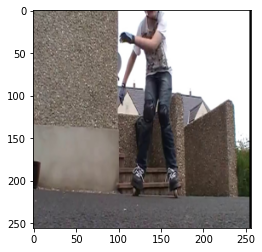

In [56]:
plt.imshow(img[idx]/255.)
plt.show()

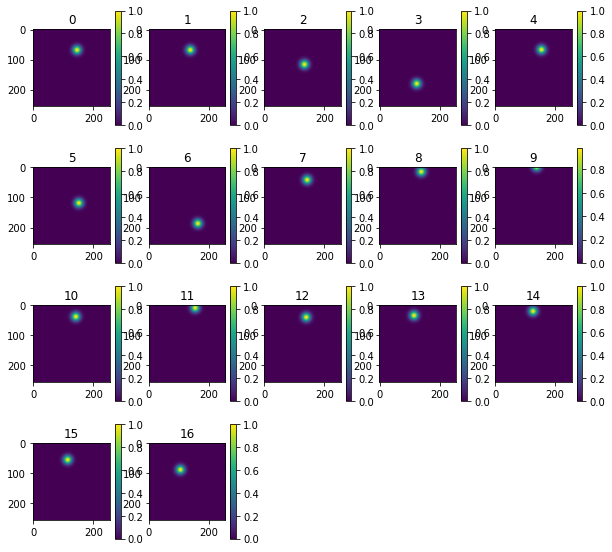

In [57]:
draw_heatmap(0, *regr)

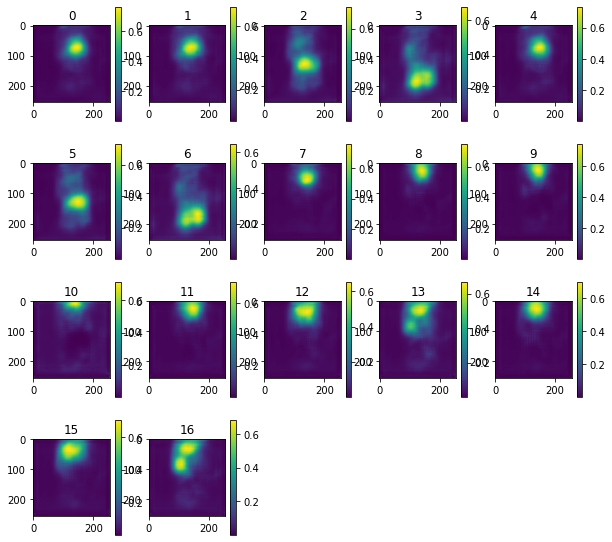

In [58]:
draw_heatmap(0, heatmap_result=result)

In [59]:
print(" MSE  loss : ", tf.math.reduce_mean(tf.keras.losses.MSE(regr[0], result)).numpy())
print(" MAE  loss : ", tf.math.reduce_mean(tf.keras.losses.MAE(regr[0], result)).numpy())
print("Hubor loss : ", tf.keras.losses.Huber()(regr[0], result).numpy())
print("Focal loss : ", criterion2(regr[0], result).numpy())
print(" EMD  loss : ", EMD_loss(regr[0], result, -1).numpy())

 MSE  loss :  0.014753149
 MAE  loss :  0.062404264
Hubor loss :  0.0073765744
Focal loss :  0.0024522597
 EMD  loss :  0.6388112


# Decode

In [60]:
# pose_scores, keypoint_scores, keypoint_coords = decode_single_poses(result[0].numpy().squeeze(axis=0),
#                     result[1].numpy().squeeze(axis=0))

# print(f'pose score : {pose_scores}')
# print(f'keypoint scores :')
# print(f'{keypoint_scores}')
# print(f'keypoint coords :')
# print(f'{keypoint_coords}')

In [61]:
pose_scores_nooff, keypoint_scores_nooff, keypoint_coords_nooff = decode_single_poses_nooff(result.numpy().squeeze(axis=0), output_stride=1.)

# pose_scores_nooff, keypoint_scores_nooff, keypoint_coords_nooff = decode_single_poses_nooff(result[0].numpy().squeeze(axis=0),
#                     result[1].numpy().squeeze(axis=0))

print(f'pose score nooff: {pose_scores_nooff}')
print(f'keypoint scores nooff:')
print(f'{keypoint_scores_nooff}')
print(f'keypoint coords nooff:')
print(f'{keypoint_coords_nooff}')

pose score nooff: [0.5157992103520561]
keypoint scores nooff:
[0.51044768 0.50023103 0.519207   0.52711332 0.50998479 0.54268795
 0.50122511 0.51993614 0.56625938 0.52331024 0.5191052  0.50627708
 0.50357515 0.50212902 0.5134005  0.50274414 0.50095284]
keypoint coords nooff:
[[ 97. 138.]
 [ 97. 146.]
 [108. 140.]
 [159. 167.]
 [ 54. 139.]
 [108. 152.]
 [167. 126.]
 [ 30. 151.]
 [  8. 154.]
 [  2. 125.]
 [  2. 117.]
 [ 20. 119.]
 [ 52. 132.]
 [ 38. 111.]
 [ 14. 160.]
 [ 65. 120.]
 [ 93. 120.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


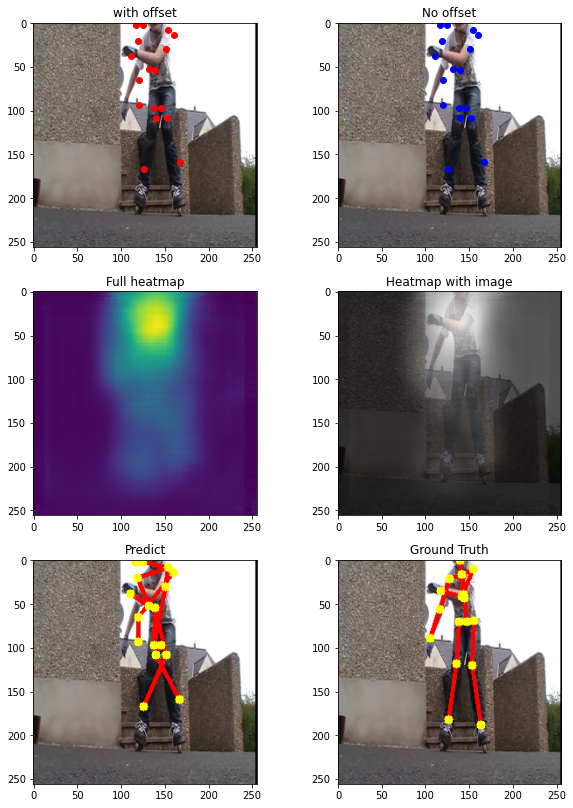

In [62]:
draw_result(img/255., idx, keypoint_coords_nooff, keypoint_coords_nooff, result, inf_gen, seed)

# Evaluate 

In [26]:
evaluate(inf_model, inf_gen)

100%|██████████| 5045/5045 [12:27<00:00,  6.75it/s]

Total accuracy : 0.09120270506617235


In [23]:
best = 0
best_idx = -1
for idx, (img, regr) in tqdm(enumerate(inf_gen)):
    result = inf_model(img)
    _, _, keypoint_coords = decode_single_poses_nooff(result.numpy().squeeze(axis=0), output_stride=1.)
    temp = pckh_05(regr[2][0], keypoint_coords)
    if temp > best:
        best = temp
        best_idx = idx

5045it [12:26,  6.76it/s]


In [24]:
best, best_idx

(0.5882352941176471, 613)